In [1]:
from skimage.util import img_as_float
from skimage.io import imread
import numpy as np
from skimage.transform import resize
from skimage.transform import rescale
from copy import copy
import pickle
import matplotlib
import os
from skimage.color import rgb2gray
from skimage.color import hsv2rgb
import random
import matplotlib.pyplot as plt
from brian2 import *
from IPython.display import clear_output
%matplotlib inline

imgDef = 128
receptiveFieldSize=int(imgDef/18)
print(receptiveFieldSize-2)
C1num = len(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2))
print(C1num)
print(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2))

5
25
range(0, 121, 5)


In [2]:
from scipy import ndimage as nd

def power_conv(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='nearest')**2 +
                   nd.convolve(image, np.imag(kernel), mode='nearest')**2)

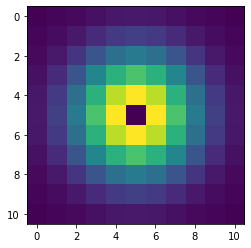

In [3]:
# Local inhibition

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, dtype=float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

kernelInhibition=makeGaussian(11, fwhm = 5)*1.15
kernelInhibition[5,5]=0

plt.figure()
plt.imshow(kernelInhibition)

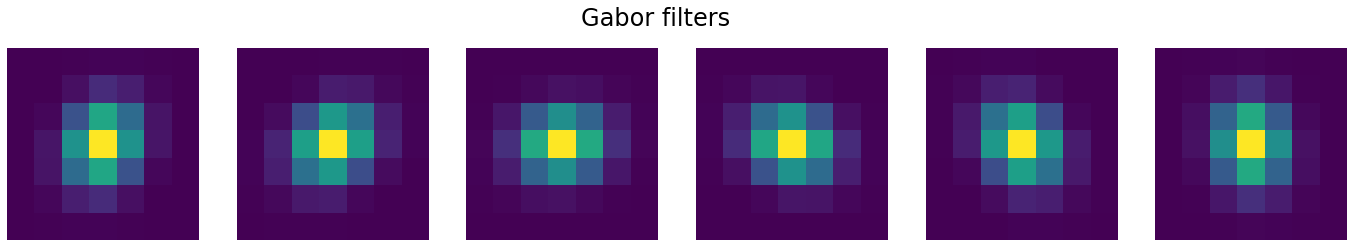

In [4]:
from skimage.filters import gabor_kernel
sigma_values = [1] 
frequency_values = [0.1] 

kernels = []
for theta in range(6):
    theta = (theta / 6. + 1/8) * np.pi
    for sigma in sigma_values:
        for frequency in frequency_values:
            kernel = gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma)
            #print(kernel.shape)
            kernels.append(kernel)

cols = 6
rows = 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 4))
fig.suptitle('Gabor filters', fontsize=24)
n=0

for y in range(0,cols):
        ax = axes[y]
        ax.imshow(np.real(kernels[n]), interpolation='none')
        n=n+1
        ax.axis('off')

In [5]:
## Dataset Upload ##
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

specific_nums = []
for num in range(10):
    specific_nums.append(x_train[y_train == num])
objects = []

digits = 2 # Number of distinct digits used in the input
num_nums_specific = int((4000 + digits - 1) / digits)
for num in range(digits):
    for numnum in range(num_nums_specific):
        objects.append(rescale(specific_nums[num][numnum], 128/28, multichannel=False))

print('Dataset contains {} pictures of {} digits'.format(len(objects), digits))

WARNING    /usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
 [py.warnings]


Dataset contains 4000 pictures of 2 digits


In [6]:
## S1 and C1 Layers ##

from tqdm.notebook import tqdm, trange

num_obj = 3501

single = False

for cnt in tqdm(range(len(objects))):
    if single:
        cnt = num_obj
    img = objects[cnt]
    if single:
        figG, axesG = plt.subplots(nrows=1, ncols=6, figsize=(24, 4))
        figG.suptitle('Gabor convolutions at different angles (S1 layer)', fontsize=24)
    spikes=np.zeros((imgDef,imgDef,6,len(sigma_values),len(frequency_values)))
    n=0
    for theta in range(6):
        for s,sigma in enumerate(sigma_values):
            for f,frequency in enumerate(frequency_values):
                spikes[:,:,theta,s,f]=resize(power_conv(img,kernels[n]), (imgDef, imgDef)) #convolutions for all thetas, sigmas, f
                if single:
                    ax = axesG[n]
                    ax.imshow(spikes[:,:,theta,s,f], interpolation='none')
                    ax.axis('off')
                n+=1

    S1ori=np.argmax(spikes, axis=2) # number of orientation propagated (C1xC1xsxf)
    S1val=np.max(spikes, axis=2) # value at this orientation
    S1ori[S1val < 0.5 * np.max(S1val)] = -1 # to cancel out cells where actually nothing but they still got some orientation (3e-1)
    C1ori=np.zeros([C1num,C1num,len(sigma_values),len(frequency_values)])
    C1lat=np.zeros([C1num,C1num,len(sigma_values),len(frequency_values)])
    if single:
        fig1, axes1 = plt.subplots(nrows=len(frequency_values), ncols=len(sigma_values), figsize=(5, 3))
        fig1.suptitle('C1 Layer - Orientation #'+str(cnt), fontsize=12);n=0
        fig2, axes2 = plt.subplots(nrows=len(frequency_values), ncols=len(sigma_values), figsize=(5, 3))
        fig2.suptitle('C1 Layer - Latency before lateral inhibition#'+str(cnt), fontsize=12);n=0
        fig3, axes3 = plt.subplots(nrows=len(frequency_values), ncols=len(sigma_values), figsize=(5, 3))
        fig3.suptitle('C1 Layer - Latency after lateral inhibition#'+str(cnt), fontsize=12);n=0
    for s,sigma in enumerate(sigma_values):
        for f,frequency in enumerate(frequency_values):
            for x,px in enumerate(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2)):
                for y,py in enumerate(range(0,imgDef-receptiveFieldSize,receptiveFieldSize-2)):
                    fstSpX,fstSpY=np.unravel_index(np.argmax(S1val[px:(px+receptiveFieldSize),py:(py+receptiveFieldSize),s,f]),(receptiveFieldSize,receptiveFieldSize))
                    C1ori[x,y,s,f]=S1ori[px+fstSpX,py+fstSpY,s,f]
                    v=S1val[px+fstSpX,py+fstSpY,s,f]
                    if v==0:
                        C1lat[x,y,s,f]=np.nan
                        C1ori[x,y,s,f]=np.nan
                    else:
                        C1lat[x,y,s,f]=1/v
            if single:
                ax1 = axes1
                im1=ax1.imshow(C1ori[:,:,s,f])
                ax1.axis('off');
                ax2 = axes2
                im2=ax2.imshow(C1lat[:,:,s,f], vmin=0,interpolation='none')
                ax2.axis('off');n+=1
    if single:
        fig1.subplots_adjust(right=0.8)
        cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
        fig1.colorbar(im1, cax=cbar_ax)
        fig2.subplots_adjust(right=0.8)
        cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
        fig2.colorbar(im2, cax=cbar_ax)
    
    flag_inhib = False
    
    #print('Total number of neurons needed: '+str(np.prod(C1ori.shape)*6))
    #print('Size of C1 layer: '+str(C1ori.reshape((C1num, C1num, len(sigma_values)*len(frequency_values))).shape))
    #print('Image reduction by a 1/'+str((imgDef**2)/(C1num**2))+' ratio.')
    
    for s,sigma in enumerate(sigma_values):
        for f,frequency in enumerate(frequency_values):
            tmp2=copy(C1lat[:,:,s,f])
            for ori in range(6):
                tmp=np.zeros((C1num,C1num))
                ori_indices = (C1ori[:,:,s,f]==ori)
                tmp[ori_indices] = 1 # binary array: whether it is current orientation or not
                tmp=nd.convolve(tmp, kernelInhibition, mode='wrap')
                tmp2[ori_indices] = clip(tmp2[ori_indices] * tmp[ori_indices], tmp2[ori_indices], None)
            if not flag_inhib:
                C1lat[:,:,s,f]=copy(tmp2)
                flag_inhib = True
            if single:
                ax3 = axes3
                im3=ax3.imshow(C1lat[:,:,s,f], vmin=0,interpolation='none')
                ax3.axis('off');
                fig3.subplots_adjust(right=0.8)
                cbar_ax = fig3.add_axes([0.85, 0.15, 0.05, 0.7])
                fig3.colorbar(im3, cax=cbar_ax)

    ## Saving the C1 layer for the first Gabor filter ##
    C1 = np.zeros([C1num, C1num, 6])
    for ori in range(6):
        tmp=np.zeros((C1num,C1num))
        tmp2=copy(C1lat[:,:,0,0])
        tmp[np.nonzero(C1ori[:,:,0,0]==ori)] = tmp2[np.nonzero(C1ori[:,:,0,0]==ori)]
        C1[:, :, ori] = copy(tmp)

    if single:
        cols = 6
        n = 0
        fig4, axes4 = plt.subplots(nrows=1, ncols=cols, figsize=(24, 4))
        fig4.suptitle('C1 Layer sparse, orientations - Latency after lateral inhibition#'+str(cnt), fontsize=24)
        for y in range(cols):
            ax4 = axes4[y]
            ax4.imshow(C1[:, :, n], vmin=0, interpolation='none')
            ax4.axis('off');
            n+=1

    ## Saving the objects: ##
    if not single:
        with open('input/mnist_C1_{}.pickle'.format(cnt), 'wb') as f:
            pickle.dump([C1, C1num], f)

    if single:
        break


  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
## Data preprocessing for S2 input ##

from random import shuffle

i_neur = []
t_neur = []

dur = num_nums_specific * digits # number of images in the input sequence
spikes_dur = 250 # duration of a spike train for 1 picture (in ms)
pic_dur = spikes_dur * 2 # total time slot for 1 picture (in ms)


count = np.arange(dur)
shuffle(count)
print("Total length of the input sequence: ", len(count))
# print(count)

per = np.empty((len(count)))

z = 0
for indx, cnt in tqdm(enumerate(count), total=dur):
    with open(os.path.join('input/mnist_C1_{}.pickle'.format(int(cnt))), 'rb') as f:
        C1, C1num = pickle.load(f)

        indices = array(range(0,C1num**2*6)) # indices of 6 arrays 25x25 for each orientation (flattened)

        times = array(C1.reshape((np.prod(C1.shape)))) / 1.

        per[indx] = np.percentile(times[times > 0], 99) 

        times[times > spikes_dur] = 0 # to cut the spikes with too large latency (larger than 500 ms)

        j = 0
        while j < len(times):
            if times[j] == 0:
                times = np.delete(times, j)
                indices = np.delete(indices, j)
                j -= 1
            j+=1

        i_neur = np.concatenate([i_neur, indices])
        t_neur = np.concatenate([t_neur, times + z * pic_dur])
        z+=1
        if z >= dur:
            break
            
print('Number of pictures: ', z)

t_neur = t_neur * ms
print('Size of the input arrays: ', t_neur.shape, i_neur.shape)
print('Unique neuron indices firing: ', len(np.unique(i_neur)))
print('Total number of neurons: ', C1num**2 * 6)


Total length of the input sequence:  4000


  0%|          | 0/4000 [00:00<?, ?it/s]

Number of pictures:  4000
Size of the input arrays:  (510253,) (510253,)
Unique neuron indices firing:  2850
Total number of neurons:  3750


Total teporal length of the full dataset: 2000.0 sec.
Total training time: 400.0 sec.


WARNING    'i' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value 3749. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'j' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Synapses with STDP:  37500


  0%|          | 0/2 [00:00<?, ?it/s]

WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0.272528963688915. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    's' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0.0 for a duration of 200.0
9.2995 s (4%) simulated in 10s, estimated 3m 25s remaining.
18.613 s (9%) simulated in 20s, estimated 3m 15s remaining.
28.0464 s (14%) simulated in 30s, estimated 3m 4s remaining.
37.5494 s (18%) simulated in 40s, estimated 2m 53s remaining.
47.1515 s (23%) simulated in 50s, estimated 2m 42s remaining.
56.7272 s (28%) simulated in 1m 0s, estimated 2m 32s remaining.
66.4673 s (33%) simulated in 1m 10s, estimated 2m 21s remaining.
76.4014 s (38%) simulated in 1m 20s, estimated 2m 9s remaining.
86.3972 s (43%) simulated in 1m 30s, estimated 1m 58s remaining.
96.4075 s (48%) simulated in 1m 40s, estimated 1m 47s remaining.
106.4645 s (53%) simulated in 1m 50s, estimated 1m 37s remaining.
116.422 s (58%) simulated in 2m 0s, estimated 1m 26s remaining.
126.4983 s (63%) simulated in 2m 10s, estimated 1m 16s remaining.
136.3843 s (68%) simulated in 2m 20s, estimated 1m 5s remaining.
146.4167 s (73%) simulated in 2m 30s, estimated 55s remain

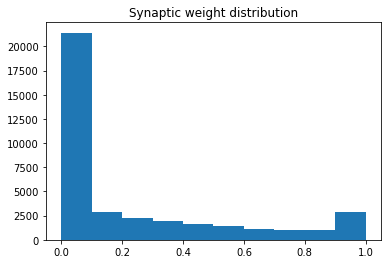

  0%|          | 0/10 [00:00<?, ?it/s]

(25, 25) (25, 25) (25, 25)


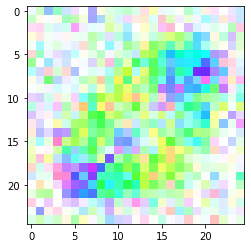

(25, 25) (25, 25) (25, 25)


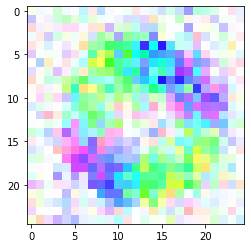

(25, 25) (25, 25) (25, 25)


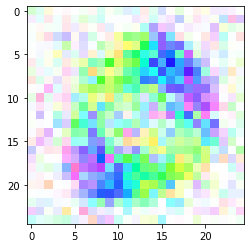

(25, 25) (25, 25) (25, 25)


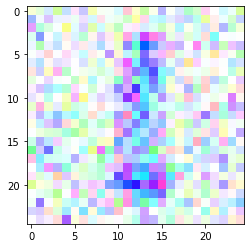

(25, 25) (25, 25) (25, 25)


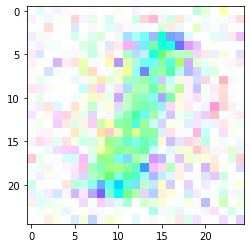

(25, 25) (25, 25) (25, 25)


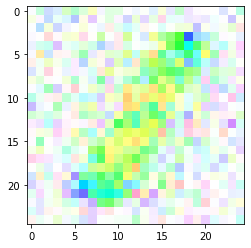

(25, 25) (25, 25) (25, 25)


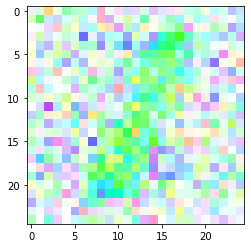

(25, 25) (25, 25) (25, 25)


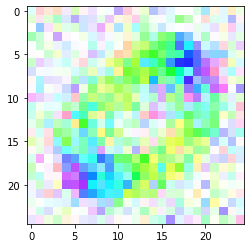

(25, 25) (25, 25) (25, 25)


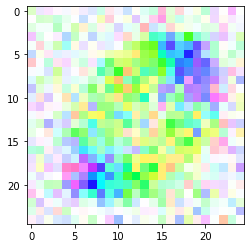

(25, 25) (25, 25) (25, 25)


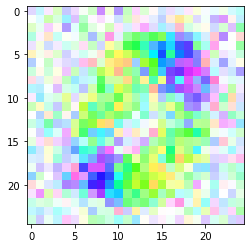

time passed: 200.0 sec
Starting simulation at t=200.0 for a duration of 200.0
9.5003 s (4%) simulated in 10s, estimated 3m 21s remaining.
19.2577 s (9%) simulated in 20s, estimated 3m 8s remaining.
28.8997 s (14%) simulated in 30s, estimated 2m 58s remaining.
38.3118 s (19%) simulated in 40s, estimated 2m 49s remaining.
47.3612 s (23%) simulated in 50s, estimated 2m 41s remaining.
56.8049 s (28%) simulated in 1m 0s, estimated 2m 31s remaining.
66.3281 s (33%) simulated in 1m 10s, estimated 2m 21s remaining.
75.8189 s (37%) simulated in 1m 20s, estimated 2m 11s remaining.
85.2649 s (42%) simulated in 1m 30s, estimated 2m 1s remaining.
94.7371 s (47%) simulated in 1m 40s, estimated 1m 51s remaining.
104.1204 s (52%) simulated in 1m 50s, estimated 1m 41s remaining.
113.4857 s (56%) simulated in 2m 0s, estimated 1m 31s remaining.
123.3557 s (61%) simulated in 2m 10s, estimated 1m 21s remaining.
133.2882 s (66%) simulated in 2m 20s, estimated 1m 10s remaining.
143.2123 s (71%) simulated in 

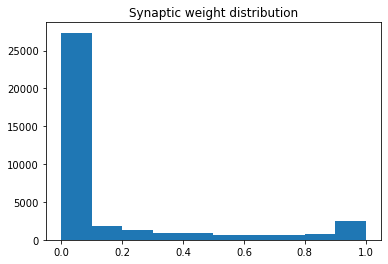

  0%|          | 0/10 [00:00<?, ?it/s]

(25, 25) (25, 25) (25, 25)


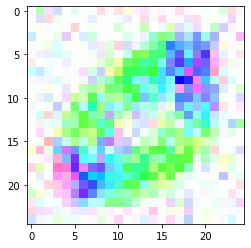

(25, 25) (25, 25) (25, 25)


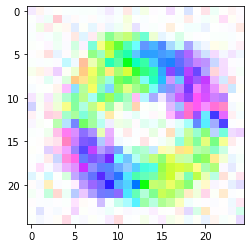

(25, 25) (25, 25) (25, 25)


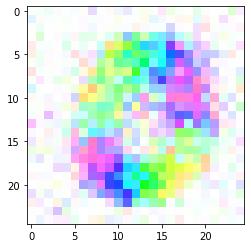

(25, 25) (25, 25) (25, 25)


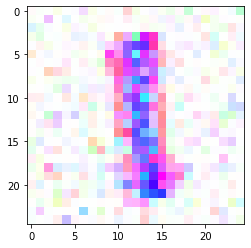

(25, 25) (25, 25) (25, 25)


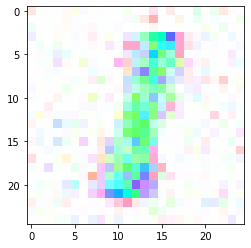

(25, 25) (25, 25) (25, 25)


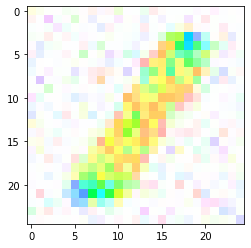

(25, 25) (25, 25) (25, 25)


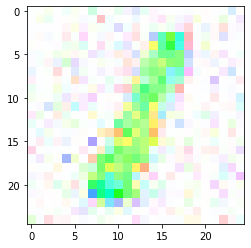

(25, 25) (25, 25) (25, 25)


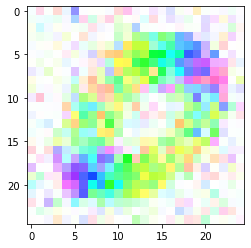

(25, 25) (25, 25) (25, 25)


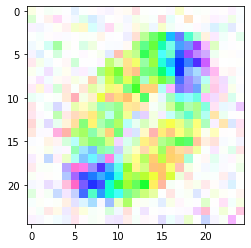

(25, 25) (25, 25) (25, 25)


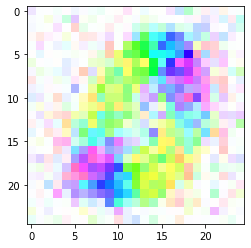

time passed: 400.0 sec


In [8]:
## S2 Layer ##

# The sinusoidal modulation in the S2 layer
freq = 8 * Hz # frequency
amp_mod = 2 * mV # amplitude

## Parameters
simulation_duration =  pic_dur / 1000 * dur * second # duration in seconds
print('Total teporal length of the full dataset: {} sec.'.format(simulation_duration / second))

# We can train on the whole dataset but 400 seconds is enough.
batch_step = 200 * second
step_num = 2
print('Total training time: {} sec.'.format(batch_step*step_num / second))

PoissonFreq = 0.8
S2Inhibition = -25 * mV

## Neurons
taum = 10 * ms
Ee = 0 * mV
vt = -54 * mV
vr = -60 * mV
El = -74 * mV
taue = 5 * ms

## STDP
taupre = 100 * ms
taupost = taupre
gmax = .05 
dApre = .02
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Setting the stage
network = Network()

## Input neurons
num_neurons = 10

input_n = NeuronGroup(C1num**2 * 6, 'spike : 1', threshold='spike>0', reset='spike=0')
input_n.spike = 0

input_spikes = SpikeGeneratorGroup(C1num**2 * 6, i_neur, t_neur)

## Input noise
stimulus = TimedArray(np.tile([PoissonFreq, PoissonFreq, 0., 0.], dur)*Hz, dt=spikes_dur/2*ms)
input_Poisson = PoissonGroup(C1num**2 * 6, rates='stimulus(t)')

network.add(input_n)
network.add(input_spikes)
network.add(input_Poisson)

## Merging the input noise and input spikes together
S_sp = Synapses(input_spikes, input_n, on_pre='spike+=1')
S_sp.connect(j='i')
network.add(S_sp)

S_poi = Synapses(input_Poisson, input_n, on_pre='spike+=1')
S_poi.connect(j='i')
network.add(S_poi)


## S2 neurons
neurons = NeuronGroup(num_neurons, '''dv/dt = (ge * (Ee-vr) + El - v + amp_mod * cos(2 * pi * (freq * t - 14/16))) / taum : volt
                                      dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='euler')
neurons.v = vr
network.add(neurons)


## C1-S2 synapses
S = Synapses(input_n, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect(p=1.0)

k = 0
for i, j in zip(S.i, S.j):
    k += 1
print('Synapses with STDP: ', k) #number of synapses

## Initial synaptic weights: normal distribution
smean = 0.7
S.w = clip(np.random.normal(gmax * smean, gmax*0.1 / 5, size=k), (smean - 0.05) * gmax, (smean + 0.05) * gmax)

network.add(S)


## Lateral S2 inhibition: If one S2 neuron is active, it inhibits the others
S_in = Synapses(neurons, neurons,
                   model='''s: volt''',
                   on_pre='v_post += s')
S_in.connect(condition='i!=j')
S_in.s = S2Inhibition

network.add(S_in)

syn_i = np.linspace(0, k-1, k)


synapse_monitor = StateMonitor(S, 'w', record=True, dt=1*second) 
network.add(synapse_monitor)

mon = SpikeMonitor(neurons, ['v'], record=True)
network.add(mon)


## Running the network
for time in trange(step_num):
    network.run(batch_step, report='text')
    plt.hist(S.w / gmax)
    plt.title("Synaptic weight distribution")
    show()
  
    for cnt in trange(num_neurons):  
        cell = S.w[cnt::num_neurons]
        cell = np.reshape(cell, (C1num, C1num, 6))
        cell_complex = np.zeros((C1num, C1num), dtype=complex)
        for theta in range(6):
            cell_complex += cell[:, :, theta] * np.exp(1j * (theta / 6. + 1/8) * np.pi)
        hue = np.angle(cell_complex)
        hue = np.interp(hue, (hue.min(), hue.max()), (0, 1))
        saturation = abs(cell_complex)
        saturation = np.interp(saturation, (saturation.min(), saturation.max()), (0, 1))
        value = np.ones((C1num, C1num))
        print(hue.shape, saturation.shape, value.shape)
        image = np.zeros((C1num, C1num, 3))
        for cnt1 in range(C1num):
            for cnt2 in range(C1num):
                image[cnt1][cnt2][0] = hue[cnt1][cnt2]
                image[cnt1][cnt2][1] = saturation[cnt1][cnt2]
                image[cnt1][cnt2][2] = value[cnt1][cnt2]
        image = hsv2rgb(image)
        imshow(image, interpolation='none')
        show()
    print('time passed: {} sec'.format((time + 1) * batch_step/second))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

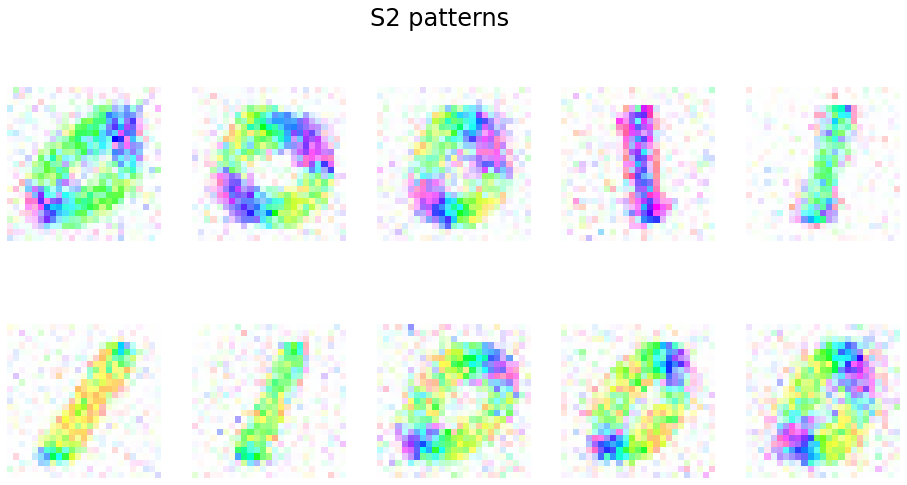

In [9]:
#Plot final weight patterns of C1-S2 connections

HSV = True

if not HSV:
    imgs = np.zeros((10, C1num, C1num))
    print(imgs.shape)
    for cnt in range(10):  
        cell = Sw[cnt::10]
        cell = cell.reshape(C1num, C1num, 6)
        img = np.mean(cell, axis=2)
        imgs[cnt, :, :] = img
else:
    imgs = np.zeros((num_neurons, C1num, C1num, 3))
    for cnt in range(num_neurons):  
        cell = S.w[cnt::num_neurons]
        cell = np.reshape(cell, (C1num, C1num, 6))
        cell_complex = np.zeros((C1num, C1num), dtype=complex)
        for theta in range(6):
            cell_complex += cell[:, :, theta] * np.exp(1j * (theta / 6. + 1/8) * np.pi)
        hue = np.angle(cell_complex)
        hue = np.interp(hue, (hue.min(), hue.max()), (0, 1))
        saturation = abs(cell_complex)
        saturation = np.interp(saturation, (saturation.min(), saturation.max()), (0, 1))
        value = np.ones((C1num, C1num))
        image = np.zeros((C1num, C1num, 3))
        for cnt1 in range(C1num):
            for cnt2 in range(C1num):
                image[cnt1][cnt2][0] = hue[cnt1][cnt2]
                image[cnt1][cnt2][1] = saturation[cnt1][cnt2]
                image[cnt1][cnt2][2] = value[cnt1][cnt2]
        image = hsv2rgb(image)
        imgs[cnt, :, :, :] = image
    
cols = 5
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8))
fig.suptitle('S2 patterns', fontsize=24)
n=0
for x in trange(0,rows):
    for y in trange(0, cols, leave=False):
        ax = axes[x][y]
        im = ax.imshow(imgs[n], vmin = imgs[n].min(), vmax=imgs[n].max(), interpolation='none', cmap='binary')
        n=n+1
        ax.axis('off')
        if n - 1 > num_neurons:
            break
    if n - 1 > num_neurons:
        break

# savefig('1d.pdf', dpi = 600)

[0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1]


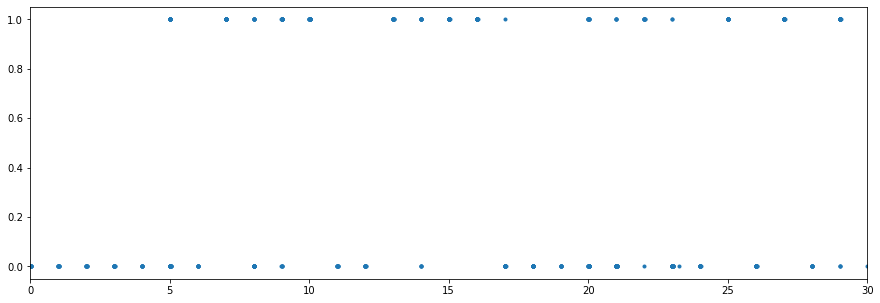

In [10]:
# This part can be used to generate inputs for the Global network

num_image = 2000
total_images = 1.1
a = pic_dur * (num_image - 0.01)/1000
b = a + (spikes_dur + pic_dur * (total_images - 1))/1000
figure(figsize=(15, 5))

# Manually written numbers of cells that "recognize" a digit 0
# has to be edited every time
zrs = [1, 2, 3, 4, 5, 8]

mon_new_i = [i not in zrs for i in mon.i]
mon_new_t = mon.t/second*2 - step_num*batch_step/second


mon_new_t = mon_new_t[mon_new_t > 0]
mon_new_i = mon_new_i[-len(mon_new_t):]

#Plot showing what digit the network chooses every time
plot(mon_new_t, mon_new_i, '.')

xlim(0, 30)
labels_export = count[2000:]//num_nums_specific
print(labels_export[:30])

file = 'input/spikes_for_global_alt.pickle'
with open(file, 'wb') as f:
    pickle.dump([mon_new_t, mon_new_i, labels_export], f)

show()